# Tensorflow Lite

Ref: [TensorFlow Lite inference](https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python)

In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import glob

## Load FaceNet

In [2]:
from facenet.facenet import load_model as load_facenet_model

In [3]:
# Load FaceNet
facenet = load_facenet_model("facenet/facenet_weights.h5")
target_shape = facenet.input_shape[1:3]
print(target_shape)

(160, 160)


## Load Images

In [16]:
def normalize_img(img: np.ndarray) -> np.ndarray:
    """Zero mean and unit variance normalizarion.

    Parameters
    ----------
    img : array

    Returns
    -------
    array
        Normalized image
    """
    mean, std = img.mean(), img.std()
    img = (img - mean) / std
    return img.astype(np.float32)

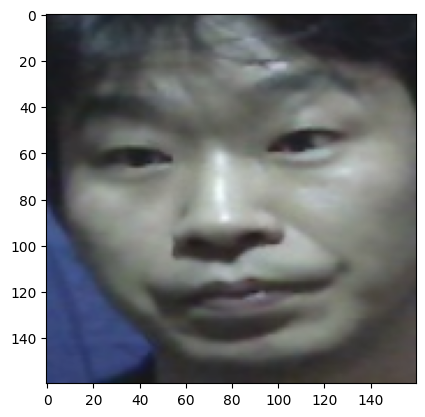

In [67]:
img = cv2.imread("dataset/casia_cropped/000/000_0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_shape)

plt.imshow(img)
img = normalize_img(img)

In [37]:
img_paths = glob.glob("dataset/casia_cropped/**/*.jpg") + glob.glob("dataset/greeninn/**/*.jpg")
img_paths

['dataset/casia_cropped\\000\\000_0.jpg',
 'dataset/casia_cropped\\000\\000_1.jpg',
 'dataset/casia_cropped\\000\\000_2.jpg',
 'dataset/casia_cropped\\000\\000_3.jpg',
 'dataset/casia_cropped\\000\\000_4.jpg',
 'dataset/casia_cropped\\001\\001_0.jpg',
 'dataset/casia_cropped\\001\\001_1.jpg',
 'dataset/casia_cropped\\001\\001_2.jpg',
 'dataset/casia_cropped\\001\\001_3.jpg',
 'dataset/casia_cropped\\001\\001_4.jpg',
 'dataset/casia_cropped\\002\\002_0.jpg',
 'dataset/casia_cropped\\002\\002_1.jpg',
 'dataset/casia_cropped\\002\\002_2.jpg',
 'dataset/casia_cropped\\002\\002_3.jpg',
 'dataset/casia_cropped\\002\\002_4.jpg',
 'dataset/greeninn\\000\\000_0.jpg',
 'dataset/greeninn\\000\\000_1.jpg',
 'dataset/greeninn\\000\\000_2.jpg',
 'dataset/greeninn\\001\\001_0.jpg',
 'dataset/greeninn\\001\\001_1.jpg',
 'dataset/greeninn\\001\\001_2.jpg',
 'dataset/greeninn\\002\\002_0.jpg',
 'dataset/greeninn\\002\\002_1.jpg',
 'dataset/greeninn\\002\\002_2.jpg']

In [38]:
imgs = list()

for img_path in img_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_shape)
    img = normalize_img(img)
    imgs.append(img)

# Convert TF Lite

In [24]:
SAVED_MODEL_PATH = "native_model"
TFLITE_FILE_PATH = "tflite_model"

In [25]:
# save native tf model
tf.saved_model.save(facenet, SAVED_MODEL_PATH)

INFO:tensorflow:Assets written to: native_model\assets


INFO:tensorflow:Assets written to: native_model\assets


In [26]:
# covert to tf lite
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()
with open(TFLITE_FILE_PATH, 'wb') as f:
    f.write(tflite_model)

## Run Inference

### Native TF

In [68]:
# native tf model
output_native = facenet.predict(np.expand_dims(img, axis=0))[0]
print(output_native)

1/1 [==============================] - 0s 29ms/step
[ 1.60688329e+00 -9.54994202e-01 -9.29808974e-01 -2.59238407e-02
  3.09061813e+00 -1.00984108e+00 -8.43380630e-01 -7.25158870e-01
  1.52072740e+00 -1.74071062e+00  1.12673581e+00 -3.24485779e-01
 -1.42161500e+00 -2.43367577e+00 -6.68637872e-01  1.41054168e-01
  5.81186175e-01  1.12971985e+00 -2.48755902e-01  3.40998858e-01
 -4.65676278e-01  2.33028159e-01 -2.09491640e-01 -7.05864906e-01
  1.58841252e-01  1.61252916e+00 -3.41674611e-02  1.01931036e-01
 -4.70875800e-01  3.83230746e-01  1.65141404e+00  5.10672927e-01
 -1.30566692e+00  5.62752068e-01 -1.37204647e+00  8.75110745e-01
 -9.26335394e-01  1.16544616e+00 -5.79355657e-01  1.38805282e+00
 -4.36144173e-01  1.03373027e+00  2.35548401e+00 -1.11739171e+00
  3.57807636e-01  7.87596762e-01  1.56279489e-01  1.21465623e+00
 -1.04352701e+00  5.78354239e-01 -7.90314257e-01 -1.28858298e-01
  8.62753987e-01  1.44644320e+00  4.94904250e-01 -1.21853447e+00
  2.69737452e-01  2.48934597e-01  1.93

### TF Lite

In [69]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [70]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3]),
  'shape_signature': array([ -1, 160, 160,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [71]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 448,
  'shape': array([  1, 128]),
  'shape_signature': array([ -1, 128]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [72]:
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))
interpreter.invoke()
output_tflite = interpreter.get_tensor(output_details[0]['index'])[0]

### Compare

In [73]:
def _cosine(a: np.ndarray, b: np.ndarray):
    """Calculate cosine similarity, range [-1, 1], between two given
    1D arrays sharing the same shape.

    Parameters
    ----------
    a : 1D array
    b : 1D array

    Returns
    -------
    float
        Cosine similarity
    """
    cosine_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    # Convert numpy float to native python float
    return cosine_sim.item()

In [74]:
(_cosine(output_native, output_tflite) + 1 )/2

0.9999999403953552

## Evaluate

In [79]:
import time

In [99]:
native_elapsed_times = list()
native_outputs = list()
for img in imgs:
    start_time = time.perf_counter()
    output = facenet.predict(np.expand_dims(img, axis=0))[0]
    elapsed_time = time.perf_counter() - start_time
    native_elapsed_times.append(elapsed_time)
    native_outputs.append(output)

1/1 [==============================] - 0s 24ms/step


In [100]:
tflite_elapsed_times = list()
tflite_outputs = list()
for img in imgs:
    start_time = time.perf_counter()
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])[0]
    elapsed_time = time.perf_counter() - start_time
    tflite_elapsed_times.append(elapsed_time)
    tflite_outputs.append(output)

In [105]:
print(f"Avg native model inference time: {np.array(native_elapsed_times).mean()} sec")
print(f"Avg tf lite model inference time: {np.array(tflite_elapsed_times).mean()} sec")

Avg native model inference time: 0.0913403041674125 sec
Avg tf lite model inference time: 0.024867541665419896 sec


In [110]:
distances = list()
for native_output, tflite_output in zip(native_outputs, tflite_outputs):
    cosine_distance = 1 - _cosine(output_native, output_tflite)
    distances.append(cosine_distance)

print(np.array(distances).mean())

1.1920928955078125e-07
